# Project Members

    Ricardo Martinez
    Christine Robinson
    Marc Gomez Freixa
    Miguel Ibarra
    Md Mabeshareul "Prottoy" Islam
    Mahmuda Sultana

    
# Imports

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy import integrate
import matplotlib.pyplot as plt

from numpy import array


import os
import sys
import time

import subprocess
import itertools as itt
from multiprocessing import Pool

%config InlineBackend.figure_format = 'svg'
%config InteractiveShell.ast_node_interactivity = 'all'

# MapK Model Variant_28

https://www.ebi.ac.uk/biomodels-main/BIOMD0000000028

    # The following is the simplified ODE model

    x1 = k2*x9 + k8*x10 + k21*x15 + k26*x16 - x1*x5*(k1 + k7) - x1*x6*(k22 + k27)
    x2 = k3*x9 + k5*x7 + k24*x12 - k4*x2*x5 - k23*x2*x6
    x3 = k9*x10 + k11*x8 + k16*x13 + k19*x14 - x3*x6*(k17 + k18) - k10*x3*x5
    x4 = k6*x7 + k12*x8 + k14*x11 - k13*x4*x6
    x5 = x9*(k2 + k3) + x7*(k5 + k6) + x10*(k8 + k9) + x8*(k11 + k12) - x1*x5*(k1 + k7) - k4*x2*x5 - k10*x3*x5
    x6 = k14*x11 + k16*x13 + k19*x14 + k21*x15 + k24*x12 + k26*x16 - x3*x6*(k17 + k18) - x1*x6*(k22 + k27) - k13*x4*x6 - k23*x2*x6
    x7 = k4*x2*x5 - x7*(k5 + k6)
    x8 = k10*x3*x5 - x8*(k11 + k12)
    x9 = k1*x1*x5 - x9*(k2 + k3)
    x10 = k7*x1*x5 - x10*(k8 + k9)
    x11 = k13*x4*x6 - x11*(k14 + k15)
    x12 = k23*x2*x6 - x12*(k24 + k25) 
    x13 = k15*x11 - k16*x13 + k17*x3*x6 
    x14 = k18*x3*x6 - x14*(k19 + k20)
    x15 = k20*x14 - k21*x15 + k22*x1*x6
    x16 = k25*x12 - k26*x16 + k27*x1*x6 
   
   
    Each Xi represents a reactant's concentration
   
    # Main Actors
    x1 = M    = un-phosphorylated ERK
    x2 = MpY  = mono-phosphorylated ERK @ Tyrosine
    x3 = MpT  = mono-phosphorylated ERK @ Threonine
    x4 = Mpp  = di-phosphorylated ERK
    
    x5 = MEK  = Kinase-Kinase
    x6 = MKP3 = Phosphatase
    
    # Concentration of Intermediate Complexes at specific events 
    # Phosphorylating
    x7 = MpY_MEK
    x8 = MpT_MEK
    
    # Assocication
    x9  = M_MEK_Y  
    x10 = M_MEK_T  
    
    #Dephosphorylating
    x11 = Mpp_MKP3 
    x12 = MpY_MKP3
    x13 = MpT_MKP3_Y 
    x14 = MpT_MKP3_T
    
    #Dissociation
    x15 = M_MKP3_T
    x16 = M_MKP3_Y
    


## [SAGE](https://cocalc.com/app)|Preliminary Work

    The SAGE platform is used to find:
        X | A*X = Y,
        
    as well as the Kernel(A) = X0
        X0 | A*X0 = 0

```python


# matrix of coefficients (A)
A = matrix(QQ, [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
                [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

n = A.ncols() # n=16

# conditional bounds vector (Y)
Y = vector(QQ, [100, 180, 800])

# solve_right in SAGE returns the matrix
# vector (X) such that A*X = Y
X = A.solve_right(Y)


####### X0 = A.right_kernel() #############
# right_kernel in SAGE returns the matrix 
# vector (X0) such that A*X0 = 0

# 'pivot' returns X0 in reduced row echelon form

# .basis() converts X_0 such that it is a basis 
X0 = A.right_kernel(basis='pivot').basis()


# The Kernel (X0) is of dimension (13 * 16)
# so we create a random vector v of len_13
# to generate a valid solution vector which 
# satisfies the conditions given by Y and
# captured in X and X0
v = vector(QQ, [1,2,3,4,5,6,7,8,9,0,1,2,3])  # must be len_13

# converts X0 to different data type
X0 = matrix(QQ, X0)

solution = X + v * X0

Y_check = sum(solution[i]*A.column(i) for i in range(n))
Y_check == Y

```


# Trajectories Graph

<Figure size 720x504 with 0 Axes>

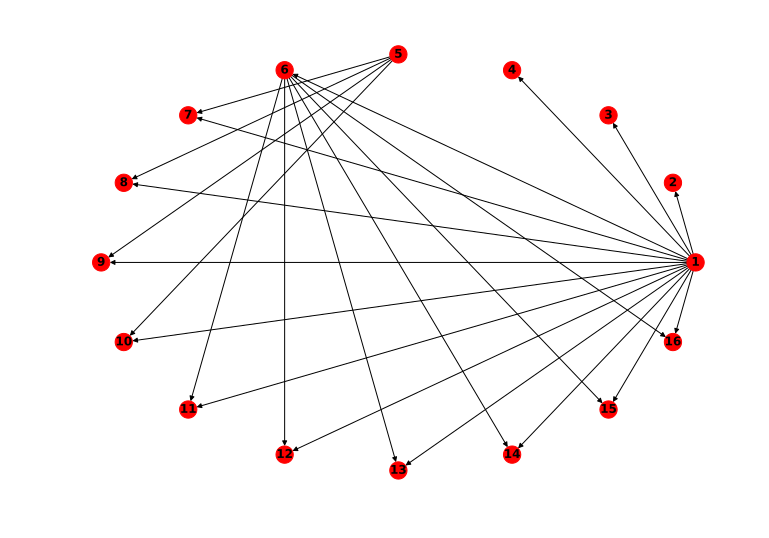

In [2]:
# NETWORK_X  library is used to visualize formed by the kernel (X0)
            
#Example
# X0 = array([[-1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],   (1, 2) (out_node, in_node)
#             [-1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],   (1, 3) 
#             [-1,  0,  0, -1,  0,  1,  0,  0,  0,  0,  0],   (1, 6) , (4, 6) 
#             [-1, ...], ...])

DG = nx.DiGraph()

# column-numbered nodes
nodes=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

n_labels={1:"M", 2:"MpY", 3:"MpT", 4:"Mpp", 5:"MEK",
          6:"MKP3:", 7:"MpY-MEK", 8:"MpT-MEK", 
          9:"M-MEK-Y", 10:"M-MEK_T", 11:"Mpp_MKP3",
         12:"MpY-MKP3", 13:"MpT-MKP3_Y", 14:"MpT_MKP3_T",
         15:"M_MKP3_T", 16:"M_MKP_Y"}

edges=[(1,2),(1,3),(1,4),(1,6),(1,7),(1,8),(1,9),
       (1,10),(1,11),(1,12),(1,13),(1,14),(1,15),
       (1,16),(5,7),(5,8),(5,9),(5,10),(6,11),
       (6,12),(6,13),(6,14),(6,15),(6,16)]

for n in nodes:
    DG.add_node(n)
    
for e in edges:
    DG.add_edge(e[0],e[1])

plt.figure(figsize=(10,7))
g1 = nx.draw_circular(DG, with_labels=True, font_weight='bold')
plt.show()

In [3]:
#Labeled

#plt.figure(figsize=(10,7))
#g2 = nx.draw_circular(DG, with_labels=True, labels=n_labels, font_weight='bold')
#plt.show()


## MapK Model Function

In [4]:
def mapK_28(init_state:list, t, k:list):
    """The following function models the ODE mapK_28 cascade"""
    
    x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16 = init_state
    
    k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,k16,k17,k18,k19,k20,k21,k22,k23,k24,k25,k26,k27 = k
    
    dx1 = k2*x9 + k8*x10 + k21*x15 + k26*x16 - x1*x5*(k1 + k7) - x1*x6*(k22 + k27) 
    dx2 = k3*x9 + k5*x7 + k24*x12 - k4*x2*x5 - k23*x2*x6 
    dx3 = k9*x10 + k11*x8 + k16*x13 + k19*x14 - x3*x6*(k17 + k18) - k10*x3*x5 
    dx4 = k6*x7 + k12*x8 + k14*x11 - k13*x4*x6 
    dx5 = x9*(k2 + k3) + x7*(k5 + k6) + x10*(k8 + k9) + x8*(k11 + k12) - x1*x5*(k1 + k7) - k4*x2*x5 - k10*x3*x5 
    dx6 = k14*x11 + k16*x13 + k19*x14 + k21*x15 + k24*x12 + k26*x16 - x3*x6*(k17 + k18) - x1*x6*(k22 + k27) - k13*x4*x6 - k23*x2*x6 
    dx7 = k4*x2*x5 - x7*(k5 + k6) 
    dx8 = k10*x3*x5 - x8*(k11 + k12) 
    dx9 = k1*x1*x5 - x9*(k2 + k3) 
    dx10= k7*x1*x5 - x10*(k8 + k9) 
    dx11= k13*x4*x6 - x11*(k14 + k15) 
    dx12= k23*x2*x6 - x12*(k24 + k25) 
    dx13= k15*x11 - k16*x13 + k17*x3*x6 
    dx14= k18*x3*x6 - x14*(k19 + k20) 
    dx15= k20*x14 - k21*x15 + k22*x1*x6 
    dx16= k25*x12 - k26*x16 + k27*x1*x6
    
    return [dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16]    

# Helper Functions

In [5]:
def parse_bertini_main_data(fl):
    """
    :param fl: file object of the main_data output from Bertini 1.6
    :type f1: file-like object 
    :return: list of solutions
    """
    it = (line.strip() for line in fl)
    number_variables = next(it)
    solution_dimension = int(number_variables[21:])
    variables = next(it)
    rank = next(it)
    _ = next(it)
    dimension_title = next(it)
    _ = next(it)
    non_singular_title = next(it)
    
    line = next(it)
    solns = []
    while line == '---------------':
        path_number = next(it)
        component_number = next(it)
        estimated_condition_number = next(it)
       
        components = []
        for i in range(solution_dimension):
            component = next(it)

            re, im = component.split(' ')
            component = float(re) + 1j * float(im)
            components.append(component)
        solns.append(components)
        
        multiplicity = next(it)
        deflations = next(it)
        line = next(it)
        
    return solns


def triage_solns(solns, atol=1e-5):
    """Segregates the REAL solutions from 'bertini' total output """
    keep = []
    for soln in solns:
        soln = np.array(soln)
        re = np.real(soln)
        im = np.imag(soln)
        if np.allclose(np.zeros(shape=im.shape), im, atol=atol) and np.all(re >= 0):
            #print(np.zeros(shape=im.shape), im)
            keep.append(re)        
    return np.array(keep)


def triage_repeater(k_x_bound, btni_in:str, output_folder:str, subfolder_format:str):
    """Function designed to call the triage solutions multiple times"""
    
    # ensures bertini folder path is unchanged by
    # the subsequent os.chdir calls
    main_work_dir = os.getcwd()
        
    subfolder=os.path.join(output_folder, subfolder_format.format(k_x_bound))
    
    if not os.path.exists(subfolder):
        os.mkdir(subfolder)
        
    os.chdir(subfolder)
    with open(os.path.join(subfolder, 'input'), 'w') as file:
        payload = btni_in.format(k_x_bound)
        file.write(payload)
        
    ###############################
    ## location of 'bertini' app ##
    ###############################
    # structured as follows only for readability #
    
    # Alternatively (and recommended): if installed properly a linux 
    # system ,the following call should run bertini:
    
        # subprocess.call(['bertini'])
    
    bertini_rel_path = "BertiniLinux64_v1.6/bertini"
    BERTINI=os.path.join(main_work_dir, bertini_rel_path)
    subprocess.run(BERTINI)
    ##### ##### ######## ####### ##
    
    with open(os.path.join(subfolder, 'main_data')) as file:
        data = parse_bertini_main_data(file)
    
    triaged = triage_solns(data)
    
    return triaged


def k_x_upper_lower_range(k_x_lower, k_x_upper, vals_dict, btni_in, k_x_str, output_folder, subfolder_fmt):
    
    # main working directory
    main_work_dir = os.getcwd()
    
    # use the function namespace to prevent shadowing
    k_x_lower, k_x_upper, values_dict = k_x_lower, k_x_upper, vals_dict
    
    output = []
    i = 0
    while k_x_upper - k_x_lower > 1:
        s = (k_x_lower + k_x_upper) / 2
        
        subfolder = os.path.join(output_folder, subfolder_fmt.format(i))
        if not os.path.exists(subfolder):
            os.mkdir(subfolder)
            
        os.chdir(subfolder)
        with open(os.path.join(subfolder, 'input'), 'w') as file:
            file.write(bertini_input.format(k_x_upper))
            
        ###############################
        ## location of 'bertini' app ##
        ###############################
        # structured as follows only for readability #

        # Alternatively (recommended) and if installed properly a linux 
        # system should be able to call it using the command:
        # subprocess.call(['bertini'])
        
        #BERT="""/home/rdmtinez/Documents/B-IT MS Program/Semester 3/Block Courses/"""
        #TINI= """Weber Modeling & Simulation/BertiniLinux64_v1.6/bertini"""
        #subprocess.run(BERT+TINI)
        
        bertini_relative_path = "BertiniLinux64_v1.6/bertini"
        BERTINI=os.path.join(main_work_dir, bertini_relative_path)
        subprocess.run(BERTINI)
        
        ###############################
        
        
        main_data_path = os.path.join(subfolder, 'main_data')
        with open(main_data_path) as file:
            data = parse_bertini_main_data(file)
        
        n = len(triage_solns(data))
        
        values_dict[s] = n
        
        output.append([k_x_lower, k_x_upper, s, n])

        if n == 1:
            print('[{:.4f}, {:.4f}] {} = {:.4f} got {}. Bisect ↑'.format(k_x_lower, k_x_upper, k_x_str, s, n))
            k_x_lower = s
        
        else: # n==3
            print('[{:.4f}, {:.4f}] {} = {:.4f} got {}. Bisect ↓'.format(k_x_lower, k_x_upper, k_x_str, s, n))
            k_x_upper = s
        
        print("Completed Search in Range [{}, {}]".format(k_x_lower, k_x_upper))        
        
        i += 1
        
    return output, values_dict


def quickplot(df):
    
    """
    # Main Actors
    x1 = M    = un-phosphorylated ERK
    x2 = MpY  = mono-phosphorylated ERK @ Tyrosine
    x3 = MpT  = mono-phosphorylated ERK @ Threonine
    x4 = Mpp  = di-phosphorylated ERK

    x5 = MEK  = Kinase-Kinase
    x6 = MKP3 = Phosphatase

    # Concentration of Intermediates Complexes at specific events 
    # Phosphorylating
    x7 = MpY_MEK
    x8 = MpT_MEK

    # Assocication
    x9  = M_MEK_Y  
    x10 = M_MEK_T  

    #Dephosphorylating
    x11 = Mpp_MKP3 
    x12 = MpY_MKP3
    x13 = MpT_MKP3_Y 
    x14 = MpT_MKP3_T

    #Dissociation
    x15 = M_MKP3_T
    x16 = M_MKP3_Y"""
    
    plt.figure(figsize=(11, 7))
    plt.plot(t, df[["x1","x2","x3","x4","x5","x6"]].sum(axis=1));
    plt.plot(t, df[["x5","x7","x8","x9","x10"]].sum(axis=1));
    plt.plot(t, df[["x6","x11","x12","x13","x14","x15","x16"]].sum(axis=1))
    plt.plot(t, df[["x1","x2","x3","x4","x7","x8","x9","x10","x11","x12","x13","x14","x15","x16"]].sum(axis=1))
    plt.plot(t, df.sum(axis=1))

    plt.title("Concentration over Time")
    plt.xlabel("Time")
    plt.ylabel("Sum of Concentrations")
               
    plt.legend(['Main Actors: $x_1 +x_2 +x_3 +x_4 +x_5 +x_6$', 
                'Kinases: $x_5 +x_7 +x_8 +x_9 +x_{10}$',
                'Phosphatase: $x_6 +x_{11} +x_{12} +x_{13} +x_{14} +x_{15} +x_{16}$',
                'Kinases & Intermediates $x_1 +x_2 +x_3 +x_6 +x_7 +x_8 +x_9 +x_{10} +x_{11} +x_{12} +x_{14} +x_{15} +x_{16}$',
                'Sum Over All $x_i$'])
    
    plt.show()

    
def quickplot2(values_dict):
    x = sorted(values_dict)
    y = [values_dict[key] for key in x]
    
    plt.figure(figsize=(11,7))
    plt.plot(x, y)
    plt.ylim(0, 4)
    plt.ylabel('Number of Fixed Points')
    plt.xlabel('k19')
    plt.show()

## Task A.2.1

### Numerical Simulation Execution

In [6]:
# conditional bounds
a,b,c = 100, 180, 800

# matrix of coefficients (A)
A = array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
           [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
           [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

# conditional bounds array
Y = array([a, b, c])

# generalization of X as given SAGE
#      X | AX = Y
X = array([c, 0, 0, 0, b, a, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


# Kernel(A) --- X0 | A*X0 = 0
# This allows the construction of a valid starting
# vector which can then be used to find the solution
# to the system of ordinary differential equations
X0 = array([[-1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [-1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [-1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [-1, 0, 0, 0,-1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [-1, 0, 0, 0,-1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [-1, 0, 0, 0,-1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
            [-1, 0, 0, 0,-1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0,-1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
            [-1, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [-1, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [-1, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])



In [7]:
# random vector
v = np.random.uniform(size=13)
v

array([0.9930791 , 0.45006758, 0.44443496, 0.42730094, 0.13391252,
       0.02508283, 0.95199877, 0.81384595, 0.01286747, 0.91210016,
       0.35561614, 0.88747746, 0.87363284])

In [8]:
# an initial state within the NullSpace of A
# AND is within the Solution Space of A bounded by
# the paremeters Y
init = X + v @ X0

init

# ensuring it is a valid solution
assert np.allclose(Y, sum(init[i] * A[:,i] for i in range(16)))

array([7.92718583e+02, 9.93079097e-01, 4.50067579e-01, 4.44434960e-01,
       1.78461705e+02, 9.61444600e+01, 4.27300940e-01, 1.33912520e-01,
       2.50828348e-02, 9.51998771e-01, 8.13845953e-01, 1.28674676e-02,
       9.12100157e-01, 3.55616136e-01, 8.87477463e-01, 8.73632841e-01])

In [9]:
# 1000 time-points between 1 - 100
t = np.linspace(1,100,1000)
t[:20]

array([1.        , 1.0990991 , 1.1981982 , 1.2972973 , 1.3963964 ,
       1.4954955 , 1.59459459, 1.69369369, 1.79279279, 1.89189189,
       1.99099099, 2.09009009, 2.18918919, 2.28828829, 2.38738739,
       2.48648649, 2.58558559, 2.68468468, 2.78378378, 2.88288288])

In [10]:
k = [ 0.005, 1, 1.08, 0.025, 1, 0.007, 0.05, 1,
0.008,0.005,1, 0.45, 0.045,1,0.092,1,0.01, 0.01, 
1, 0.5, 0.086, 0.0011, 0.01, 1,0.47,0.14,0.0018]

solution = integrate.odeint(mapK_28, init, t, args=(k,))

In [11]:
df = pd.DataFrame(solution, columns=["x1","x2","x3","x4","x5","x6","x7","x8","x9",
                                     "x10","x11","x12","x13","x14","x15","x16"])
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16
0,792.718583,0.993079,0.450068,0.444435,178.461705,96.144460,0.427301,0.133913,0.025083,0.951999,0.813846,0.012867,0.912100,0.355616,0.887477,0.873633
1,606.682313,2.013416,0.582588,0.376827,9.989831,79.665312,0.515399,0.126283,14.282609,155.085877,0.879934,0.122240,0.875071,0.347137,7.109433,11.000873
2,588.755770,3.338127,0.741280,0.352603,5.971371,67.216409,0.509848,0.111491,13.474066,159.933225,0.901664,0.286597,0.845910,0.343750,11.808383,18.597287
3,577.212140,4.516741,0.892969,0.350312,5.911891,57.060271,0.516435,0.098803,12.505776,160.967095,0.900762,0.472282,0.821624,0.342819,15.645726,24.756516
4,567.711329,5.580590,1.040663,0.360153,5.973515,48.719219,0.538381,0.088236,11.698963,161.700905,0.887292,0.653741,0.799905,0.342346,18.807417,29.790081


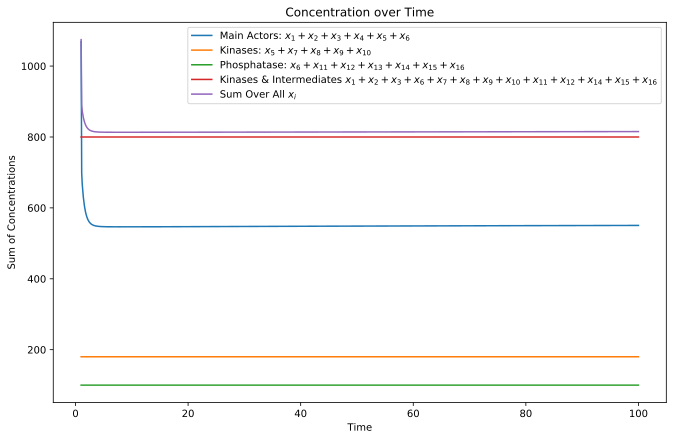

In [12]:
quickplot(df)

## Task A.2.2
    
    Perform similar computations as in Task A.2.1, but with initial values
    k28 = 100
    k29 = 180
    k30 = 1100

In [13]:
# initialize with new bounds
a, b, c = 100, 50, 1100
X = array([c, 0, 0, 0, b, a, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

v = np.random.uniform(size=13)

In [14]:
#initial condition
init = X + v @ X0

t = np.linspace(1,100,1000)
k = [0.005, 1, 1.08, 0.025, 1, 0.007, 0.05, 1,0.008,
     0.005, 1, 0.45, 0.045, 1, 0.092, 1,0.01, 0.01, 
     1, 0.5, 0.086, 0.0011, 0.01, 1,0.47,0.14,0.0018]

In [15]:
solution = integrate.odeint(mapK_28, init, t, args=(k,))

In [16]:
df = pd.DataFrame(solution, columns=["x1","x2","x3","x4","x5","x6","x7","x8","x9",
                                     "x10","x11","x12","x13","x14","x15","x16" ])
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16
0,1092.791493,0.673591,0.753987,0.247369,48.268631,96.197810,0.035878,0.446714,0.734432,0.514345,0.040362,0.873388,0.877193,0.993939,0.705213,0.312095
1,1020.420206,1.114632,0.869146,0.193403,1.114271,71.483116,0.047593,0.389984,4.586817,43.861335,0.112294,0.820951,0.858186,0.918148,10.137137,15.670168
2,1002.070127,1.581918,0.996329,0.172389,0.979002,53.841761,0.046259,0.338216,4.184068,44.452454,0.148343,0.786667,0.832844,0.844462,16.918836,26.627087
3,988.691310,2.004166,1.124964,0.166746,0.984768,41.002418,0.046033,0.293428,3.842138,44.833632,0.166632,0.757570,0.802574,0.773593,21.901477,34.595735
4,978.759218,2.394311,1.253545,0.169058,0.988904,31.587228,0.046793,0.254696,3.561055,45.148553,0.174991,0.727715,0.768653,0.706057,25.601107,40.434249


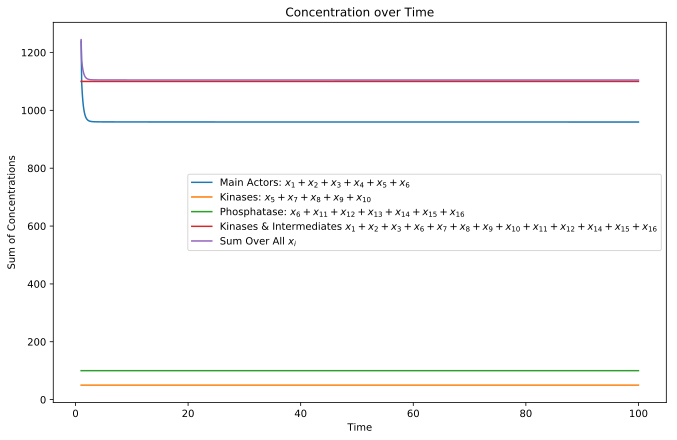

In [17]:
quickplot(df)

## Task A.2.3


#### Using the Bertini homotopy solver to obtain solutions:
    
* Compute solutions for varying values of \$k_{30} \in [800, 1100]$
* Determine the No. of Real Solutions


In [18]:
######################################################
## the input to the 'bertini' application           ##
## k30 --the overall concentration-- to be varied   ##
## k28 -- Phosphatase + Kinase_Phosphatase Intermediates ##
## k29 -- Kinase + Kinase_Kinase Intermediates      ##
######################################################

bertini_input = """
CONFIG
TRACKTYPE: 1;
INPUT
function y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12, y13, y14, y15, y16, y17, y18, y19;
variable_group x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16;
constant k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15, k16, k17, k18, k19, k20, k21, k22, k23, k24, k25, k26, k27;

k1 = 0.005 ;
k2 = 1; 
k3 = 1.08; 
k4 = 0.025; 
k5 = 1; 
k6 = 0.007; 
k7 = 0.05; 
k8 = 1; 
k9 = 0.008; 
k10 = 0.005; 
k11 = 1; 
k12 = 0.45; 
k13 = 0.045; 
k14 = 1; 
k15 = 0.092; 
k16 = 1; 
k17 = 0.01; 
k18 = 0.01; 
k19 = 1; 
k20 = 0.5; 
k21 = 0.086; 
k22 = 0.0011; 
k23 = 0.01; 
k24 = 1; 
k25 = 0.47; 
k26 = 0.14; 
k27 = 0.0018;  

k28 = 100;
k29 = 180;
k30 = {};

y1 = k2*x9 + k8*x10 + k21*x15 + k26*x16 - x1*x5*(k1 + k7) - x1*x6*(k22 + k27); 
y2 = k3*x9 + k5*x7 + k24*x12 - k4*x2*x5 - k23*x2*x6; 
y3 = k9*x10 + k11*x8 + k16*x13 + k19*x14 - x3*x6*(k17 + k18) - k10*x3*x5; 
y4 = k6*x7 + k12*x8 + k14*x11 - k13*x4*x6; 
y5 = x9*(k2 + k3) + x7*(k5 + k6) + x10*(k8 + k9) + x8*(k11 + k12) - x1*x5*(k1 + k7) - k4*x2*x5 - k10*x3*x5; 
y6 = k14*x11 + k16*x13 + k19*x14 + k21*x15 + k24*x12 + k26*x16 - x3*x6*(k17 + k18) - x1*x6*(k22 + k27) - k13*x4*x6 - k23*x2*x6; 
y7 = k4*x2*x5 - x7*(k5 + k6); 
y8 = k10*x3*x5 - x8*(k11 + k12); 
y9 = k1*x1*x5 - x9*(k2 + k3); 
y10 = k7*x1*x5 - x10*(k8 + k9); 
y11 = k13*x4*x6 - x11*(k14 + k15); 
y12 = k23*x2*x6 - x12*(k24 + k25); 
y13 = k15*x11 - k16*x13 + k17*x3*x6; 
y14 = k18*x3*x6 - x14*(k19 + k20); 
y15 = k20*x14 - k21*x15 + k22*x1*x6; 
y16 = k25*x12 - k26*x16 + k27*x1*x6; 

y17 = x6 - k28 + x11 + x12 + x13 + x14 + x15 + x16; 
y18 = x5 - k29 + x7 + x8 + x9 + x10; 
y19 = x1 - k30 + x2 + x3 + x4 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14 + x15 + x16; 

END;
"""

### Bertini Solver Execution

In [19]:
### EXECUTE THIS ONLY ONCE###
### or hardcode main_work directory

### if you experience an error,  reset notebook ###

main_dir = os.getcwd()
os.chdir(main_dir)
main_dir

'/home/rdmtinez/Documents/B-IT MS Program/Semester 3/Block Courses/Weber Modeling & Simulation'

In [20]:
#######################################
## Bertini runs output Folder        ## 
## ENSURE RELEVANT WORKING DIRECTORY ##
#######################################


out_folder = os.getcwd()+'/mapk_28/'

if not os.path.exists(out_folder):
    os.mkdir(out_folder)

subfolder_fmt = "input{:04}"

In [21]:
#################
##### Bounds ####
#################
k_30_lower = 800
k_30_upper = 1100


# lower-bound solution
k_30_lower_soln = triage_repeater(k_30_lower, bertini_input, out_folder, subfolder_fmt)
os.chdir(main_dir)

In [22]:
# upper-bound solution
k_30_upper_soln = triage_repeater(k_30_upper, bertini_input, out_folder, subfolder_fmt)
os.chdir(main_dir)

In [23]:
k_30_lower_soln
print("No. Real Solutions:", len(k_30_upper_soln))
print()

k_30_upper_soln
print("No. Real Solution:", len(k_30_lower_soln))

array([[125.87674519, 235.1938361 ,  71.66042906, 105.49306836,
         13.20369019,   5.02038852,  77.09599174,   3.26269691,
          3.99528256,  82.44233859,  21.82484296,   8.03241112,
          5.60551751,   2.3984213 ,  22.02739342,  35.09102518]])

No. Real Solutions: 3



array([[2.73624515e+01, 1.47993257e+02, 1.14571501e+02, 5.60453660e+02,
        2.77254659e+01, 2.65540303e+00, 1.01866484e+02, 1.09536146e+01,
        1.82364595e+00, 3.76307894e+01, 6.13281736e+01, 2.67334518e+00,
        8.68452709e+00, 2.02822341e+00, 1.27213474e+01, 9.90898030e+00],
       [1.88778002e+02, 3.62079713e+02, 1.12063108e+02, 1.69282195e+02,
        8.91385855e+00, 3.28916054e+00, 8.01272927e+01, 3.44453343e+00,
        4.04504906e+00, 8.34692663e+01, 2.29449032e+01, 8.10162113e+00,
        5.79686663e+00, 2.45729036e+00, 2.22285866e+01, 3.51815715e+01],
       [1.09659575e+00, 1.21299120e+01, 4.00416933e+01, 8.89325105e+02,
        1.20301129e+02, 2.29217660e+00, 3.62274606e+01, 1.66105549e+01,
        3.17119490e-01, 6.54373550e+00, 8.40037168e+01, 1.89142180e-01,
        8.64616828e+00, 6.11884217e-01, 3.58961696e+00, 6.67294919e-01]])

No. Real Solution: 1


## Task A.2.4
#### Using the Computations from Task A.2.3:
* Determine approximately (by bisecting values up to one digit of accuracy) the value of $k_{30}$ at which the system changes its behavior (from a single fixed point to 3 fixed points).

### Execution

In [24]:
values_dict_30 = {k_30_lower: len(k_30_lower_soln), k_30_upper: len(k_30_upper_soln)}

In [25]:
##############################
##Bertini runs output Folder## 
##############################
out_folder = os.getcwd()+'/mapk_28/'
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

subfolder_fmt = "input{:04}"

In [26]:
# ranged solution
k_30_lower, k_30_upper = 800.0, 1100.0
k_30_range, values_dict_30  = k_x_upper_lower_range(k_30_lower, k_30_upper, 
                                                values_dict_30, bertini_input,
                                                "k_30", out_folder, subfolder_fmt)
os.chdir(main_dir)

[800.0000, 1100.0000] k_30 = 950.0000 got 3. Bisect ↓
Completed Search in Range [800.0, 950.0]
[800.0000, 950.0000] k_30 = 875.0000 got 3. Bisect ↓
Completed Search in Range [800.0, 875.0]
[800.0000, 875.0000] k_30 = 837.5000 got 3. Bisect ↓
Completed Search in Range [800.0, 837.5]
[800.0000, 837.5000] k_30 = 818.7500 got 3. Bisect ↓
Completed Search in Range [800.0, 818.75]
[800.0000, 818.7500] k_30 = 809.3750 got 3. Bisect ↓
Completed Search in Range [800.0, 809.375]
[800.0000, 809.3750] k_30 = 804.6875 got 3. Bisect ↓
Completed Search in Range [800.0, 804.6875]
[800.0000, 804.6875] k_30 = 802.3438 got 3. Bisect ↓
Completed Search in Range [800.0, 802.34375]
[800.0000, 802.3438] k_30 = 801.1719 got 1. Bisect ↑
Completed Search in Range [801.171875, 802.34375]
[801.1719, 802.3438] k_30 = 801.7578 got 1. Bisect ↑
Completed Search in Range [801.7578125, 802.34375]


In [27]:
k_30_lower, k_30_upper = 950.0, 1100.0
k_30_range, values_dict_30  = k_x_upper_lower_range(k_30_lower, k_30_upper, 
                                                values_dict_30, bertini_input,
                                                "k_30", out_folder, subfolder_fmt)
os.chdir(main_dir)

[950.0000, 1100.0000] k_30 = 1025.0000 got 3. Bisect ↓
Completed Search in Range [950.0, 1025.0]
[950.0000, 1025.0000] k_30 = 987.5000 got 3. Bisect ↓
Completed Search in Range [950.0, 987.5]
[950.0000, 987.5000] k_30 = 968.7500 got 2. Bisect ↓
Completed Search in Range [950.0, 968.75]
[950.0000, 968.7500] k_30 = 959.3750 got 3. Bisect ↓
Completed Search in Range [950.0, 959.375]
[950.0000, 959.3750] k_30 = 954.6875 got 3. Bisect ↓
Completed Search in Range [950.0, 954.6875]
[950.0000, 954.6875] k_30 = 952.3438 got 3. Bisect ↓
Completed Search in Range [950.0, 952.34375]
[950.0000, 952.3438] k_30 = 951.1719 got 3. Bisect ↓
Completed Search in Range [950.0, 951.171875]
[950.0000, 951.1719] k_30 = 950.5859 got 3. Bisect ↓
Completed Search in Range [950.0, 950.5859375]


In [28]:
# output of data
print("k_30_range: ", k_30_range)
print()
print("values_dictionary:\n", values_dict_30)

k_30_range:  [[950.0, 1100.0, 1025.0, 3], [950.0, 1025.0, 987.5, 3], [950.0, 987.5, 968.75, 2], [950.0, 968.75, 959.375, 3], [950.0, 959.375, 954.6875, 3], [950.0, 954.6875, 952.34375, 3], [950.0, 952.34375, 951.171875, 3], [950.0, 951.171875, 950.5859375, 3]]

values_dictionary:
 {800: 1, 1100: 3, 950.0: 3, 875.0: 3, 837.5: 3, 818.75: 3, 809.375: 3, 804.6875: 3, 802.34375: 3, 801.171875: 1, 801.7578125: 1, 1025.0: 3, 987.5: 3, 968.75: 2, 959.375: 3, 954.6875: 3, 952.34375: 3, 951.171875: 3, 950.5859375: 3}


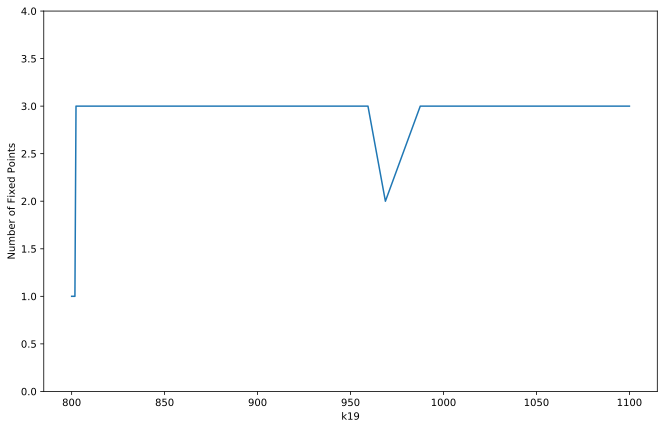

In [29]:
#values_dictionary = {800: 1, 1100: 3, 950.0: 2, 875.0: 3, 837.5: 3, 818.75: 3,
#809.375: 3, 804.6875: 3, 802.34375: 3, 801.171875: 1, 801.7578125: 1, 1025.0: 3,
#987.5: 3, 968.75: 3, 959.375: 3, 954.6875: 3, 952.34375: 3, 951.171875: 3, 950.5859375: 3}


quickplot2(values_dict_30)

## Task A.2.5

#### Take your favorite parameter $k_f$

#### Search the literature for values of $k_f$

#### Systematically determine the number of real solutions of the system in which k30 = 800, 1100, and all other parameters (except $k_f$) have the values given above, and $k_f$ is varied by two order of magnitudes around the value given above
    

## Helper Functions 2

In [30]:
def folder_er(out_folder, subfolder_fmt, mod_params, k_30_vals, btini_in, stock_const):
    """this function is used to generate the folder structure used by the Bertini solver"""
    
    col_modified = []
    col_params = []

    for k_i, k_30_val in itt.product(mod_params, k_30_vals):

        only_k30_mod = stock_const.copy()
        only_k30_mod['k30'] = k_30_val

        col_modified.append(k_i);
        col_params.append(only_k30_mod);

        for k_i_val in k_i_space[k_i]:
            k_i_params = stock_const.copy()

            k_i_params[k_i] = k_i_val
            k_i_params['k30'] = k_30_val

            col_modified.append(k_i)
            col_params.append(k_i_params)

    col_folders = []

    for i, params in enumerate(col_params):

        out_subfolder_path = os.path.join(out_folder, subfolder_fmt.format(i))
        if not os.path.exists(out_subfolder_path):
            os.mkdir(out_subfolder_path)

        with open(os.path.join(out_subfolder_path, 'input'), 'w') as file:
            out_input = btini_in.format(**params)
            file.write(out_input)

        col_folders.append(out_subfolder_path)
        
    return col_modified, col_folders, col_params


def subprocess_bertini(path,home):
    
    # main working directory and bertini application location
    main_work_dir = home
    bertini_relative_path = "BertiniLinux64_v1.6/bertini"
    BERTINI=os.path.join(main_work_dir, bertini_relative_path)
    
    os.chdir(path)

    if path.endswith('00/'):
        t = time.time()
        
                    
        ###############################
        ## location of 'bertini' app ##
        ###############################
        # structured as follows only for readability #

        # Alternatively (recommended) and if installed properly a linux 
        # system should be able to call it using the command:
        # subprocess.call(['bertini'])
        
        #BERT="""/home/rdmtinez/Documents/B-IT MS Program/Semester 3/Block Courses/"""
        #TINI= """Weber Modeling & Simulation/BertiniLinux64_v1.6/bertini"""
        #subprocess.run(BERT+TINI)
        

        subprocess.run(BERTINI)
        
        ###############################
        
        print('{} {} took {:.2f} seconds'.format(time.strftime('%H:%M'), path, time.time() - t))
    else:  
        
        subprocess.run(BERTINI)
        
    for i in range(1, 13):
        os.remove('startRPD_{}'.format(i))


def quickplot3(results_df, parameters_to_mod, m=2, n=1):
    """plots the variables you've chosen to test
    m * n = # parameters_to_mod"""
    
   
    cd = {0: 'red', 1: 'orange', 2: 'green', 3: 'blue'}
    colors = results_df['fixed'].map(lambda x: cd[x])
    
    fig, axes = plt.subplots(m, n, figsize=(10.5, 11))

    leg, *axes_i = axes.ravel()

    leg.axis('off')
    leg_t = "Fixed Point Color Map:\n{}".format('\n'.join('{}: {}'.format(k, v) for k, v in cd.items()))
    leg.text(0, 0.5, leg_t, fontsize=16, verticalalignment='center', linespacing=2.0)

    for k_i, ax in zip(parameters_to_mod, axes_i):
        filt = results_df['modified'] == k_i
        x = results_df.loc[filt, k_i]
        y = results_df.loc[filt, 'k30']

        fixed = colors[filt]

        ax.set_xlabel('{}'.format(k_i))
        ax.set_ylabel('k30')
        ax.set_xscale('log')
        ax.axvline(stock_constants[k_i], color='grey', linestyle='--')
        ax.scatter(x, y, c=fixed, lw=0, s=40)

    plt.tight_layout(pad=2)
    plt.show()

    
def results_to_csv(main_dir):
    """saves results to main directory
    and returns data as list for plotting"""
    
    n_fixeds = []
    soln_df_data = []

    #### MAIN DIR ####
    ms_base = main_dir

    for i, path in enumerate(col_folders):
        main_data_path = os.path.join(path, 'main_data')
        with open(main_data_path) as file:
            data = parse_bertini_main_data(file)

        solutions = triage_solns(data, 1e-5)

        for j, solution in enumerate(solutions, start=1):
            soln_df_data.append([i, path, j] + list(solution))

        n_solutions = len(solutions)
        n_fixeds.append(n_solutions)

    results_df['fixed'] = n_fixeds
    results_df.columns.name = 'Run Number'
    
    # saves the results onto the main directory
    results_df.to_csv(os.path.join(ms_base, 'results.csv'))
    
    return soln_df_data, results_df

### Parameter Space Exploration execution

In [ ]:
# Parameters which to vary, one can set their own list
# but should modifity the bertini input accordingly

##########################################################
# NOTE: you can change/add 'parameters_to_mod" to any    #
# to anything you desire, however ensure that you        #
# also change the bertini_input string below accordingly #
# Be warned that the more parameters you add, the more   #
# computational power/time that will be required in order#
# to accomplish the task in a reasonable amount of time  #
# this one parameter 'k5' varies along with 'k30' and    #
# takes about 3 hours to complete                        #
##########################################################

parameters_to_mod = 'k5',
print(', '.join(parameters_to_mod))

In [ ]:
# given parameter settings
stock_ks = {"k1":0.005, "k2":1, "k3":1.08, "k4":0.025,
            "k5":1, "k6":0.007, "k7":0.05, "k8":1, 
            "k9":0.008, "k10":0.005, "k11":1,"k12":0.45,
            "k13":0.045, "k14":1, "k15":0.092, "k16":1,
            "k17":0.01,"k18":0.01, "k19":1, "k20":0.5, 
            "k21":0.086, "k22":0.0011, "k23":0.01, "k24":1,
            "k25":0.47, "k26":0.14, "k27":0.0018, "k28":100,
            "k29":180, "k30":800}

In [ ]:
# dictionary holding the parameters to vary
stock_constants = {k: v for k, v in stock_ks.items() if k in parameters_to_mod}
stock_constants

In [ ]:
# using log base in order to increase the space to be explored while
# using less values altogether to reduce the overall complexity
k_i_space_size = 20
k_i_space_width = 1
k_i_space = {}
for p in parameters_to_mod:
    l = np.log10(stock_constants[p])
    rl = int(round(l))
    k_i_space[p] = np.logspace(rl - k_i_space_width, rl + k_i_space_width, k_i_space_size)

k_i_space

In [ ]:
# the range to which vary k_30
k_30_space_size = 10
k_30_vals = np.linspace(800, 1100.0, k_30_space_size)

# only 10 divisions between the range
k_30_vals

In [ ]:
############################################
## the input to the 'bertini' application ##
############################################

bertini_input = """
CONFIG
TRACKTYPE: 1;
INPUT
function y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12, y13, y14, y15, y16, y17, y18, y19;
variable_group x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16;
constant k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15, k16, k17, k18, k19, k20, k21, k22, k23, k24, k25, k26, k27;

k1 = 0.005 ;
k2 = 1; 
k3 = 1.08; 
k4 = 0.025; 
k5 = {k5}; 
k6 = 0.007; 
k7 = 0.05; 
k8 = 1; 
k9 = 0.008; 
k10 = 0.005; 
k11 = 1; 
k12 = 0.45; 
k13 = 0.045; 
k14 = 1; 
k15 = 0.092; 
k16 = 1; 
k17 = 0.01; 
k18 = 0.01; 
k19 = 1; 
k20 = 0.5; 
k21 = 0.086; 
k22 = 0.0011; 
k23 = 0.01; 
k24 = 1; 
k25 = 0.47; 
k26 = 0.14; 
k27 = 0.0018;  

k28 = 100;
k29 = 180;
k30 = {k30};

y1 = k2*x9 + k8*x10 + k21*x15 + k26*x16 - x1*x5*(k1 + k7) - x1*x6*(k22 + k27); 
y2 = k3*x9 + k5*x7 + k24*x12 - k4*x2*x5 - k23*x2*x6; 
y3 = k9*x10 + k11*x8 + k16*x13 + k19*x14 - x3*x6*(k17 + k18) - k10*x3*x5; 
y4 = k6*x7 + k12*x8 + k14*x11 - k13*x4*x6; 
y5 = x9*(k2 + k3) + x7*(k5 + k6) + x10*(k8 + k9) + x8*(k11 + k12) - x1*x5*(k1 + k7) - k4*x2*x5 - k10*x3*x5; 
y6 = k14*x11 + k16*x13 + k19*x14 + k21*x15 + k24*x12 + k26*x16 - x3*x6*(k17 + k18) - x1*x6*(k22 + k27) - k13*x4*x6 - k23*x2*x6; 
y7 = k4*x2*x5 - x7*(k5 + k6); 
y8 = k10*x3*x5 - x8*(k11 + k12); 
y9 = k1*x1*x5 - x9*(k2 + k3); 
y10 = k7*x1*x5 - x10*(k8 + k9); 
y11 = k13*x4*x6 - x11*(k14 + k15); 
y12 = k23*x2*x6 - x12*(k24 + k25); 
y13 = k15*x11 - k16*x13 + k17*x3*x6; 
y14 = k18*x3*x6 - x14*(k19 + k20); 
y15 = k20*x14 - k21*x15 + k22*x1*x6; 
y16 = k25*x12 - k26*x16 + k27*x1*x6; 

y17 = x6 - k28 + x11 + x12 + x13 + x14 + x15 + x16; 
y18 = x5 - k29 + x7 + x8 + x9 + x10; 
y19 = x1 - k30 + x2 + x3 + x4 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14 + x15 + x16; 

END;
"""

In [ ]:
##############################
##Bertini runs output Folder## 
##############################
out_folder = os.getcwd()+'/mapk_28_T5/'

if not os.path.exists(out_folder):
    os.mkdir(out_folder)

subfolder_fmt = "input{:04}/"

In [ ]:
# create the folder system for the desginated 
# variables and parameter settings to be varied
col_modified, col_folders, col_params = folder_er(out_folder, subfolder_fmt,
                                                  parameters_to_mod, k_30_vals, 
                                                  bertini_input, stock_constants);

In [ ]:
results_df = pd.DataFrame(col_params)
results_df['modified'] = col_modified
results_df['Path'] = col_folders
results_df.head(3)

# this feeds into the subprocess_bertini() function only
col_folders2 = [(i, main_dir) for i in col_folders]


In [ ]:
###################################################################
# This cell took about 55 minutes to run on 8 cores.
# Don't accidentally run it unless you want to do this all again!
# Change to True to DO IT!!!
###################################################################

do_it = False

if do_it:
    t = time.time()
    with Pool() as pool:
        pool.starmap(subprocess_bertini, col_folders2)
    print(time.time() - t)

    
###################################################################
###################################################################
###################################################################
###################################################################

In [ ]:
soln_df_data,results_df = results_to_csv(main_dir)

In [ ]:
component_labels = ['Component {}'.format(i) for i in range(1, 17)]
col_labels = ['Run Number', 'Path', 'Solution Number'] + component_labels

solutions_df = pd.DataFrame(soln_df_data, columns=col_labels)
solutions_df.head(1)
solutions_df.to_csv(os.path.join(main_dir, 'solutions.csv'), index=False)

In [ ]:
quickplot3( results_df, parameters_to_mod, m=2, n=1)